In [1]:
# Cell 1: Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [2]:
# Cell 2: Load Data and Preprocess Function
def load_data(filepath):
    """
    Loads the bank data, preprocesses it, and returns the scaled feature matrix.
    """
    # Load the dataset
    data = pd.read_csv(filepath, sep=';')

    # --- Preprocessing ---

    # 1. Label Encoding for categorical features
    categorical_cols = [
        'job', 'marital', 'education', 'default', 'housing',
        'loan', 'contact', 'month', 'poutcome', 'y'
    ]

    le = LabelEncoder()
    data_encoded = data.copy()
    for col in categorical_cols:
        data_encoded[col] = le.fit_transform(data_encoded[col])

    # 2. Feature Selection
    features = [
        'age', 'balance', 'campaign', 'pdays', 'previous', 'job',
        'marital', 'education', 'default', 'housing', 'loan'
    ]

    X = data_encoded[features]

    # 3. Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print("Data loaded and preprocessed successfully.")
    print(f"Feature matrix shape: {X_scaled.shape}")

    # --- Screenshot 1: Feature Correlation Matrix ---
    plt.figure(figsize=(12, 10))
    sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Matrix (Screenshot 1)')
    plt.savefig('screenshot_1_correlation_matrix.png')
    plt.show()

    return data, X_scaled

In [3]:
# Cell 3: Apply PCA for Dimensionality Reduction Function
def apply_pca(x, n_components=2):
    """
    Applies PCA to the data and returns the PCA object and transformed data.
    """
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(x)

    print("\n--- PCA Results ---")
    print(f"Explained variance by {n_components} components: {np.sum(pca.explained_variance_ratio_):.4f}")
    print(f"Individual explained variance: {pca.explained_variance_ratio_}")

    # --- Screenshot 2a: Explained Variance by Component ---
    plt.figure(figsize=(8, 5))
    plt.bar(range(n_components), pca.explained_variance_ratio_, alpha=0.7, align='center')
    plt.title('Explained Variance by Component (Screenshot 2a)')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(range(n_components))
    plt.savefig('screenshot_2a_pca_variance.png')
    plt.show()

    return pca, X_pca

In [4]:
# Cell 4: K-Means from Scratch Class
class KMeansScratch:
    """
    Implements the K-means clustering algorithm from scratch.
    """
    def __init__(self, n_clusters, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _init_centroids(self, X):
        """Initializes centroids by randomly selecting points from the dataset."""
        np.random.seed(self.random_state)
        n_samples, _ = X.shape
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_indices]

    def _assign_clusters(self, X):
        """Assigns each data point to the closest centroid."""
        distances = cdist(X, self.centroids, 'euclidean')
        self.labels = np.argmin(distances, axis=1)

    def _update_centroids(self, X):
        """Updates centroids to be the mean of all points in their cluster."""
        new_centroids = np.zeros_like(self.centroids)
        for k in range(self.n_clusters):
            cluster_points = X[self.labels == k]
            if len(cluster_points) > 0:
                new_centroids[k] = cluster_points.mean(axis=0)
        return new_centroids

    def fit(self, X):
        """Runs the K-means algorithm until convergence or max_iters."""
        self._init_centroids(X)

        for _ in range(self.max_iters):
            old_centroids = self.centroids
            self._assign_clusters(X)
            new_centroids = self._update_centroids(X)

            if np.all(old_centroids == new_centroids):
                break
            self.centroids = new_centroids

    def _calculate_inertia(self, X):
        """Calculates the sum of squared distances of samples to their closest cluster center (inertia)."""
        inertia = 0
        for k in range(self.n_clusters):
            cluster_points = X[self.labels == k]
            if len(cluster_points) > 0:
                distances = cdist(cluster_points, [self.centroids[k]], 'euclidean')
                inertia += np.sum(distances**2)
        return inertia

In [5]:
# Cell 5: Find Optimal Clusters for KMeans (Elbow & Silhouette) Function
def find_optimal_clusters(x, max_clusters=10):
    """
    Tests K from 2 to max_clusters to find optimal K using Elbow and Silhouette.
    """
    inertias = {}
    silhouette_scores = {}

    K = range(2, max_clusters + 1)

    print("\n--- Finding Optimal K ---")
    for k in K:
        kmeans = KMeansScratch(n_clusters=k, random_state=42)
        kmeans.fit(x)

        inertia = kmeans._calculate_inertia(x)
        inertias[k] = inertia

        score = silhouette_score(x, kmeans.labels)
        silhouette_scores[k] = score

        print(f"K={k}: Inertia={inertia:.2f}, Silhouette Score={score:.4f}")

    return inertias, silhouette_scores

In [6]:
# Cell 6: Helper Functions (Scikit-learn KMeans & Plotting)
from sklearn.cluster import KMeans

def perform_kmeans_clustering(x, n_clusters):
    """
    Performs KMeans clustering using scikit-learn.
    """
    if n_clusters is None:
        print("n_clusters not set. Finding optimal K first.")
        return None, None

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(x)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    inertia = kmeans.inertia_

    print(f"\n--- Scikit-learn KMeans (K={n_clusters}) ---")
    print(f"Inertia: {inertia:.2f}")
    print(f"Silhouette Score: {silhouette_score(x, labels):.4f}")

    return kmeans, labels, centroids

def plot_clusters_pca(X_pca_df, kmeans_model, pca_obj, title):
    """
    Plots the clustered data on the PCA 2D plane.
    """
    plt.figure(figsize=(10, 7))

    sns.scatterplot(
        data=X_pca_df,
        x='PC1',
        y='PC2',
        hue='cluster',
        palette='viridis',
        alpha=0.6,
        legend='full'
    )

    if hasattr(kmeans_model, 'centroids'): # Our scratch model
        centroids_pca = pca_obj.transform(kmeans_model.centroids)
    else: # sklearn model
        centroids_pca = pca_obj.transform(kmeans_model.cluster_centers_)

    plt.scatter(
        centroids_pca[:, 0],
        centroids_pca[:, 1],
        c='red',
        s=250,
        marker='X',
        label='Centroids'
    )

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.savefig('screenshot_4_final_clusters.png')
    plt.show()

Data loaded and preprocessed successfully.
Feature matrix shape: (45211, 11)


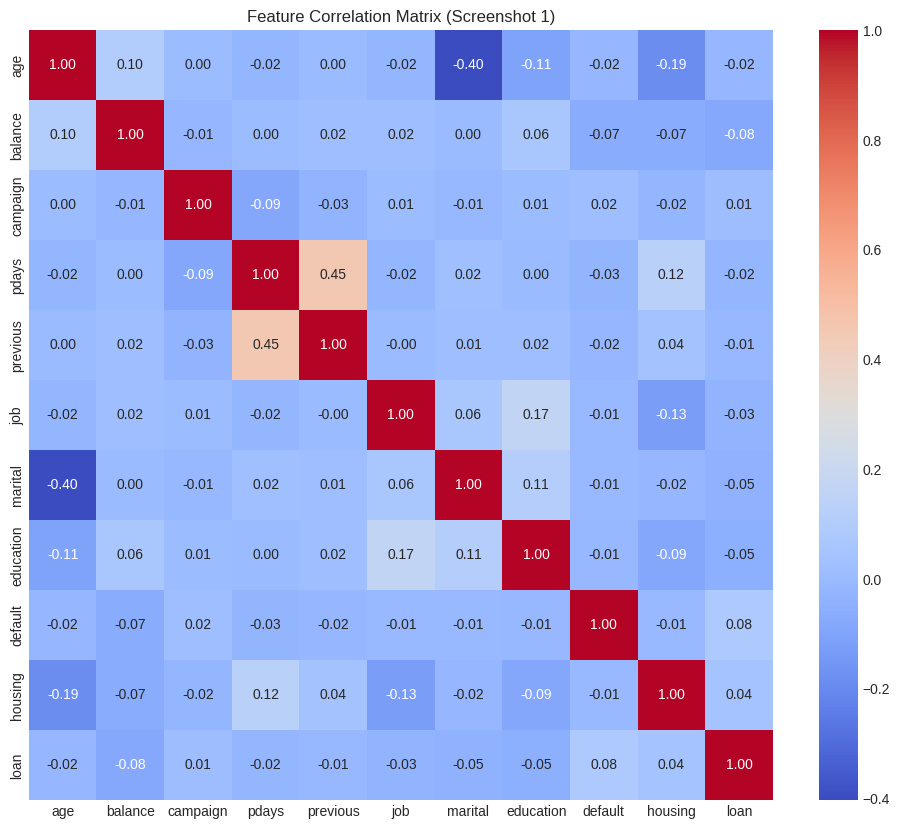

In [8]:
# Cell 7: Load the data
# This will also display Screenshot 1
data, X_scaled = load_data('bank-full.csv')


--- PCA Results ---
Explained variance by 2 components: 0.2731
Individual explained variance: [0.14023902 0.13283388]


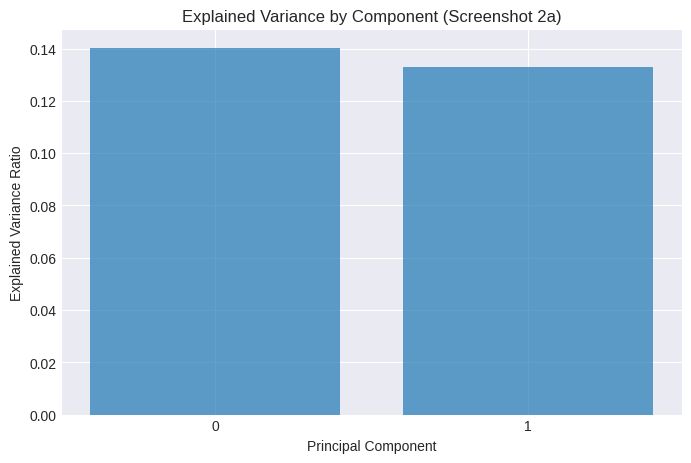

In [9]:
# Cell 8: Apply PCA
# This will display Screenshot 2a
pca, X_pca = apply_pca(X_scaled, n_components=2)

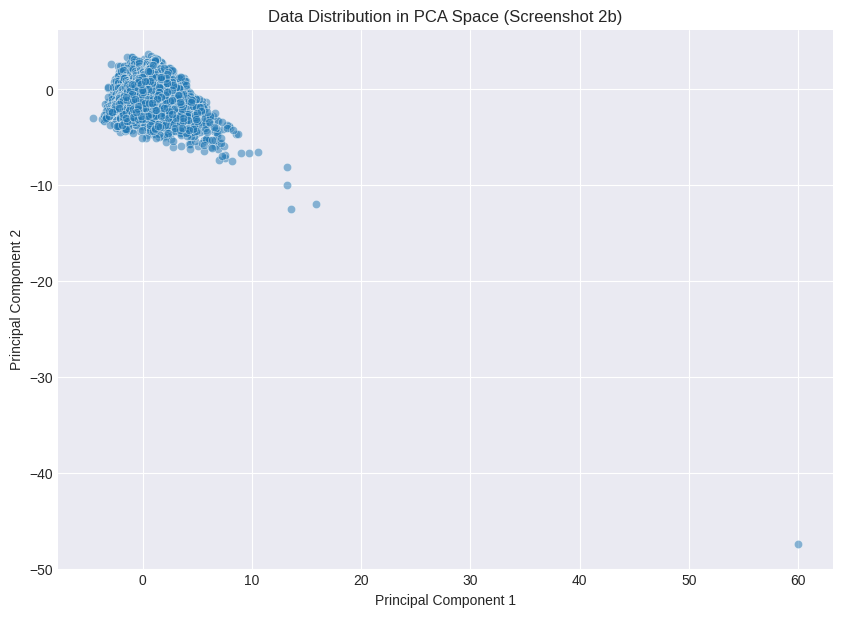

In [10]:
# Cell 9: Plot PCA Data Distribution (Screenshot 2b)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', alpha=0.5)
plt.title('Data Distribution in PCA Space (Screenshot 2b)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('screenshot_2b_pca_distribution.png')
plt.show()

In [11]:
# Cell 10: Find Optimal K (Elbow & Silhouette)
# This will run K-Means for K=2 through 10
inertias, silhouette_scores = find_optimal_clusters(X_scaled, max_clusters=10)


--- Finding Optimal K ---
K=2: Inertia=448367.87, Silhouette Score=0.1343
K=3: Inertia=417022.57, Silhouette Score=0.1295
K=4: Inertia=377639.13, Silhouette Score=0.1417
K=5: Inertia=346566.73, Silhouette Score=0.1559
K=6: Inertia=324528.15, Silhouette Score=0.1618
K=7: Inertia=304001.41, Silhouette Score=0.1673
K=8: Inertia=274104.06, Silhouette Score=0.1582
K=9: Inertia=248977.92, Silhouette Score=0.1786
K=10: Inertia=241532.31, Silhouette Score=0.1715


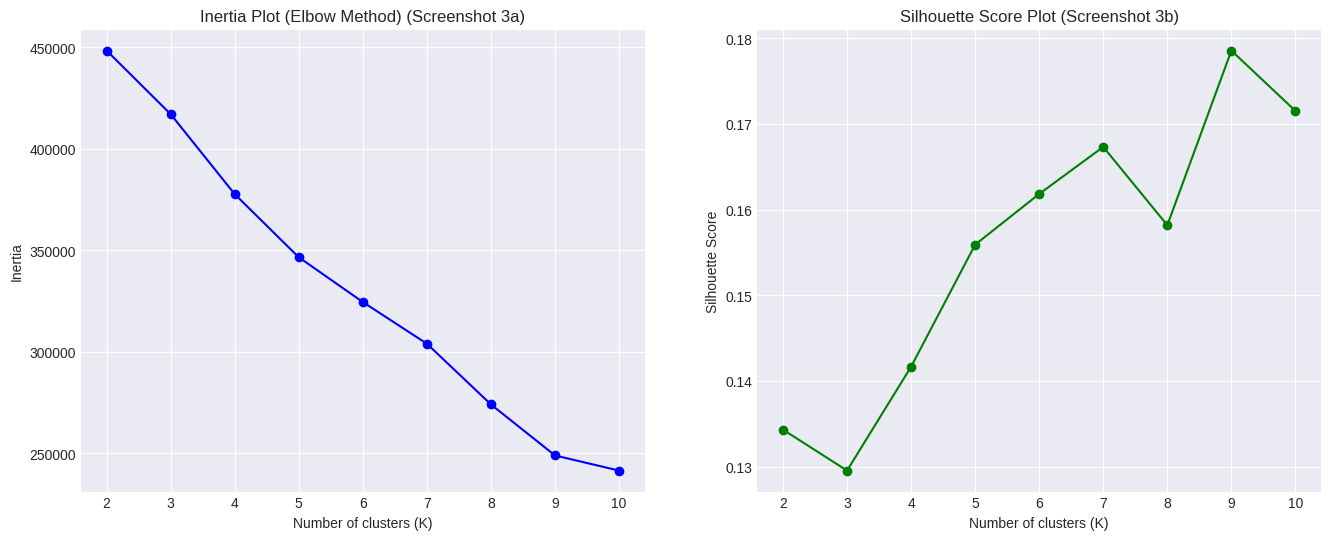

In [12]:
# Cell 11: Plot Elbow and Silhouette (Screenshot 3)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Inertia Plot (Elbow)
ax1.plot(list(inertias.keys()), list(inertias.values()), 'bo-')
ax1.set_title('Inertia Plot (Elbow Method) (Screenshot 3a)')
ax1.set_xlabel('Number of clusters (K)')
ax1.set_ylabel('Inertia')

# Silhouette Score Plot
ax2.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'go-')
ax2.set_title('Silhouette Score Plot (Screenshot 3b)')
ax2.set_xlabel('Number of clusters (K)')
ax2.set_ylabel('Silhouette Score')

plt.savefig('screenshot_3_elbow_silhouette.png')
plt.show()

In [13]:
# Cell 12: Run Final Clustering with Optimal K
OPTIMAL_K = 4

print(f"\n--- Running final 'from scratch' model with K={OPTIMAL_K} ---")
kmeans_final = KMeansScratch(n_clusters=OPTIMAL_K, random_state=42)
kmeans_final.fit(X_scaled)

# Add cluster labels to our PCA dataframe for plotting
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca_df['cluster'] = kmeans_final.labels

print("Clustering complete.")
print(f"Final Inertia: {kmeans_final._calculate_inertia(X_scaled):.2f}")
print(f"Final Silhouette Score: {silhouette_score(X_scaled, kmeans_final.labels):.4f}")


--- Running final 'from scratch' model with K=4 ---
Clustering complete.
Final Inertia: 377639.13
Final Silhouette Score: 0.1417


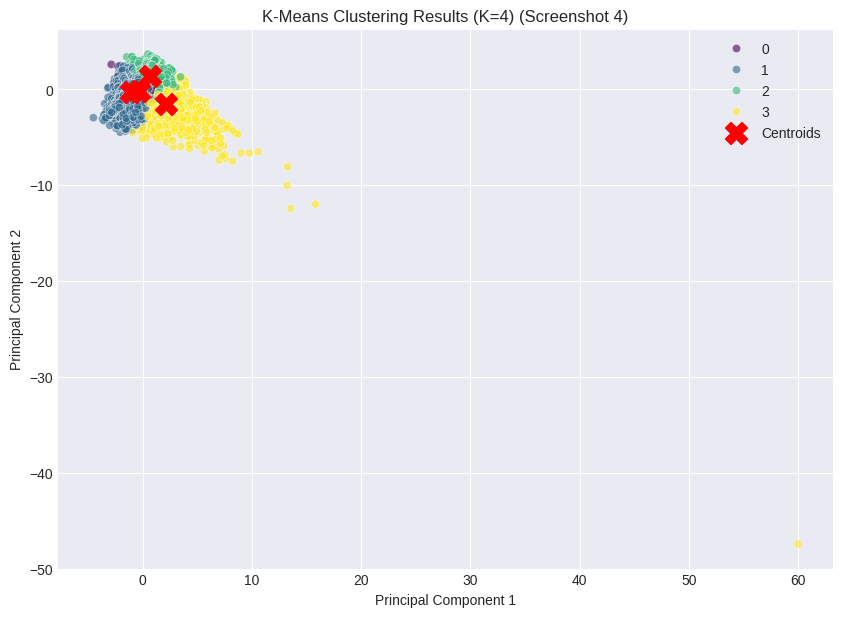

In [14]:
# Cell 13: Plot Final Clustering Results (Screenshot 4)
plot_clusters_pca(
    X_pca_df,
    kmeans_final,
    pca, # Pass the pca object
    f'K-Means Clustering Results (K={OPTIMAL_K}) (Screenshot 4)'
)


/tmp/ipython-input-1482393443.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=kmeans_final.labels, palette='viridis')


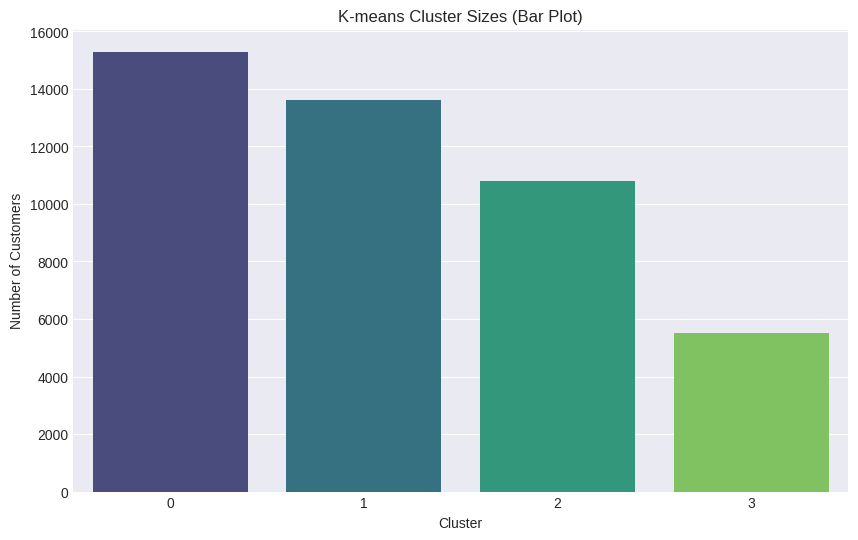

/tmp/ipython-input-1482393443.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='silhouette_val', data=X_pca_df, palette='viridis')


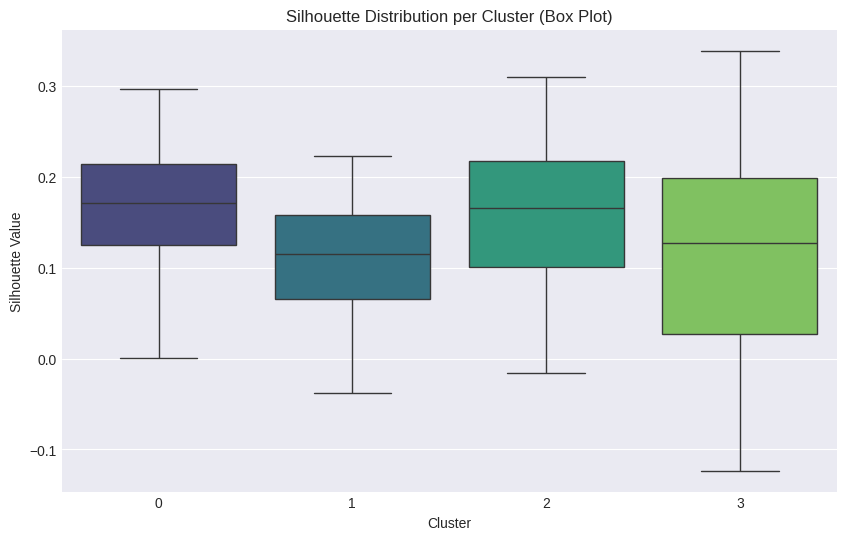

In [15]:
# Cell 14: Bonus Plots (from PDF instructions)

# (Bonus) K-means Cluster Sizes
plt.figure(figsize=(10, 6))
sns.countplot(x=kmeans_final.labels, palette='viridis')
plt.title('K-means Cluster Sizes (Bar Plot)')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.savefig('bonus_cluster_sizes.png')
plt.show()

# (Bonus) Silhouette Distribution per Cluster
from sklearn.metrics import silhouette_samples

sample_silhouette_values = silhouette_samples(X_scaled, kmeans_final.labels)
X_pca_df['silhouette_val'] = sample_silhouette_values

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='silhouette_val', data=X_pca_df, palette='viridis')
plt.title('Silhouette Distribution per Cluster (Box Plot)')
plt.xlabel('Cluster')
plt.ylabel('Silhouette Value')
plt.savefig('bonus_silhouette_distribution.png')
plt.show()